# Exploratory Data Analysis – Adult Income Dataset

EDA focused on **fairness** with respect to the sensitive variables **sex** and **race**.

We will:

- Inspect the target label and sensitive variable distributions.
- Explore income differences across sex and race.
- Look at how key numeric features (age, education, hours per week, capital gains) relate to income.
- Check that train/test splits are balanced, especially for the sensitive attributes.

## 1. Imports, styling and helper functions

In [2]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

%matplotlib inline

# --- Visual style (aligned with slides) ---
# Approximate color palette used in the presentation:
PRESENTATION_COLORS = ['#1f77b4', '#ff7f0e', '#2ca02c', '#17becf']  # blue, orange, green, cyan

sns.set_style('whitegrid')
sns.set_palette(PRESENTATION_COLORS)
plt.rcParams['figure.figsize'] = (8, 4)
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False

# --- Small plotting helpers so we can reuse them later ---


def plot_group_counts(df, group_col, ax=None, normalize=False,
                      title=None, ylabel=None, rotation=0):
    """Bar plot of counts (or proportions) for a categorical column."""
    ax = ax or plt.gca()
    vc = df[group_col].value_counts(normalize=normalize).sort_values(ascending=False)
    vc.plot(kind='bar', ax=ax)
    ax.set_title(title or f'{group_col} distribution')
    ax.set_xlabel(group_col)
    ax.set_ylabel(ylabel or ('Proportion' if normalize else 'Count'))
    ax.set_xticklabels(ax.get_xticklabels(), rotation=rotation, ha='right')
    return ax


def plot_group_positive_rate(df, group_col, target_col='income_binary',
                             ax=None, title=None, rotation=0):
    """Bar plot of positive outcome rate P(target=1 | group_col)."""
    ax = ax or plt.gca()
    rate = (
        df.groupby(group_col)[target_col]
        .mean()
        .sort_values(ascending=False)
    )
    rate.plot(kind='bar', ax=ax)
    ax.set_ylim(0, 1)
    ax.set_title(title or f'{target_col} rate by {group_col}')
    ax.set_xlabel(group_col)
    ax.set_ylabel('P(income > 50K)')
    ax.axhline(df[target_col].mean(),
               color='gray', linestyle='--', linewidth=1,
               label='Overall mean')
    ax.legend(loc='upper right')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=rotation, ha='right')
    return ax


def plot_numeric_by_target(df, num_col, target_col='income_binary', bins=40):
    """Side-by-side histograms of a numeric column split by the binary target."""
    fig, ax = plt.subplots(1, 1, figsize=(6, 4))
    for value, label, color in [
        (0, '<=50K', PRESENTATION_COLORS[0]),
        (1, '>50K', PRESENTATION_COLORS[1]),
    ]:
        subset = df[df[target_col] == value][num_col]
        ax.hist(subset, bins=bins, alpha=0.6, label=label,
                density=True, color=color)
    ax.set_title(f'{num_col} by income group')
    ax.set_xlabel(num_col)
    ax.set_ylabel('Density')
    ax.legend()
    fig.tight_layout()
    return fig, ax


## 2. Load data and create binary target

In [3]:
PROJECT_ROOT = Path('..').resolve()
data_path = PROJECT_ROOT / 'data' / 'processed' / 'adult' / 'adult_model_ready.csv'

df_full = pd.read_csv(data_path)

print(f'Loaded dataset with shape: {df_full.shape}')
print('Columns:')
print(df_full.columns.tolist())

target_col = 'income'

# Typical Adult dataset has labels like '<=50K' and '>50K'
df_full['income_binary'] = (
    df_full[target_col].astype(str).str.contains('>50K').astype(int)
)

if 'split' in df_full.columns:
    df_train = df_full[df_full['split'] == 'train'].copy()
    df_test = df_full[df_full['split'] == 'test'].copy()
else:
    df_train = df_full.copy()
    df_test = None

print(f'\nTrain size: {len(df_train)}')
print(f'Test size: {len(df_test) if df_test is not None else 0}')

print('\nIncome (original labels):')
display(df_full[target_col].value_counts(normalize=True).rename('proportion'))

print('\nIncome_binary distribution:')
display(df_full['income_binary'].value_counts(normalize=True).rename('proportion'))


Loaded dataset with shape: (45194, 16)
Columns:
['age', 'workclass', 'fnlwgt', 'education', 'education_num', 'marital_status', 'occupation', 'relationship', 'race', 'sex', 'capital_gain', 'capital_loss', 'hours_per_week', 'native_country', 'income', 'split']

Train size: 30139
Test size: 15055

Income (original labels):


income
<=50K    0.752047
>50K     0.247953
Name: proportion, dtype: float64


Income_binary distribution:


income_binary
0    0.752047
1    0.247953
Name: proportion, dtype: float64

## 3. Basic structure & missing values

In [4]:
df_full.info()
display(df_full.describe(include='number'))
display(df_full.describe(include='object'))

missing_counts = df_full.isna().sum()
missing_ratio = missing_counts / len(df_full)
missing = (
    pd.concat([missing_counts, missing_ratio], axis=1)
    .rename(columns={0: 'n_missing', 1: 'frac_missing'})
)
missing = missing[missing['n_missing'] > 0].sort_values('frac_missing', ascending=False)
display(missing)

if not missing.empty:
    fig, ax = plt.subplots(1, 1)
    missing['frac_missing'].plot(kind='bar', ax=ax)
    ax.set_ylabel('Fraction missing')
    ax.set_title('Missing value rate by feature')
    fig.tight_layout()
else:
    print('No missing values found.')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45194 entries, 0 to 45193
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             45194 non-null  int64 
 1   workclass       45194 non-null  object
 2   fnlwgt          45194 non-null  int64 
 3   education       45194 non-null  object
 4   education_num   45194 non-null  int64 
 5   marital_status  45194 non-null  object
 6   occupation      45194 non-null  object
 7   relationship    45194 non-null  object
 8   race            45194 non-null  object
 9   sex             45194 non-null  object
 10  capital_gain    45194 non-null  int64 
 11  capital_loss    45194 non-null  int64 
 12  hours_per_week  45194 non-null  int64 
 13  native_country  45194 non-null  object
 14  income          45194 non-null  object
 15  split           45194 non-null  object
 16  income_binary   45194 non-null  int64 
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


,age,fnlwgt,education_num,capital_gain,capital_loss,hours_per_week,income_binary
count,45194.000000,4.519400e+04,45194.000000,45194.000000,45194.000000,45194.000000,45194.000000
mean,38.551755,1.897379e+05,10.119109,1102.112736,88.650308,40.941209,0.247953
std,13.215806,1.056407e+05,2.552057,7508.705003,405.075515,12.006449,0.431829
min,17.000000,1.349200e+04,1.000000,0.000000,0.000000,1.000000,0.000000
25%,28.000000,1.173922e+05,9.000000,0.000000,0.000000,40.000000,0.000000
50%,37.000000,1.783120e+05,10.000000,0.000000,0.000000,40.000000,0.000000
75%,47.000000,2.379030e+05,13.000000,0.000000,0.000000,45.000000,0.000000
max,90.000000,1.490400e+06,16.000000,99999.000000,4356.000000,99.000000,1.000000


,workclass,education,marital_status,occupation,relationship,race,sex,native_country,income,split
count,45194,45194,45194,45194,45194,45194,45194,45194,45194,45194
unique,7,16,7,14,6,5,2,41,2,2
top,Private,HS-grad,Married-civ-spouse,Craft-repair,Husband,White,Male,United-States,<=50K,train
freq,33281,14777,21048,6015,18659,38877,30509,41270,33988,30139


,n_missing,frac_missing


No missing values found.


## 4. Target and sensitive attribute distributions

We focus on the sensitive attributes **sex** and **race**, since these are the
groups for which we later compute SPD/DI in the presentation.

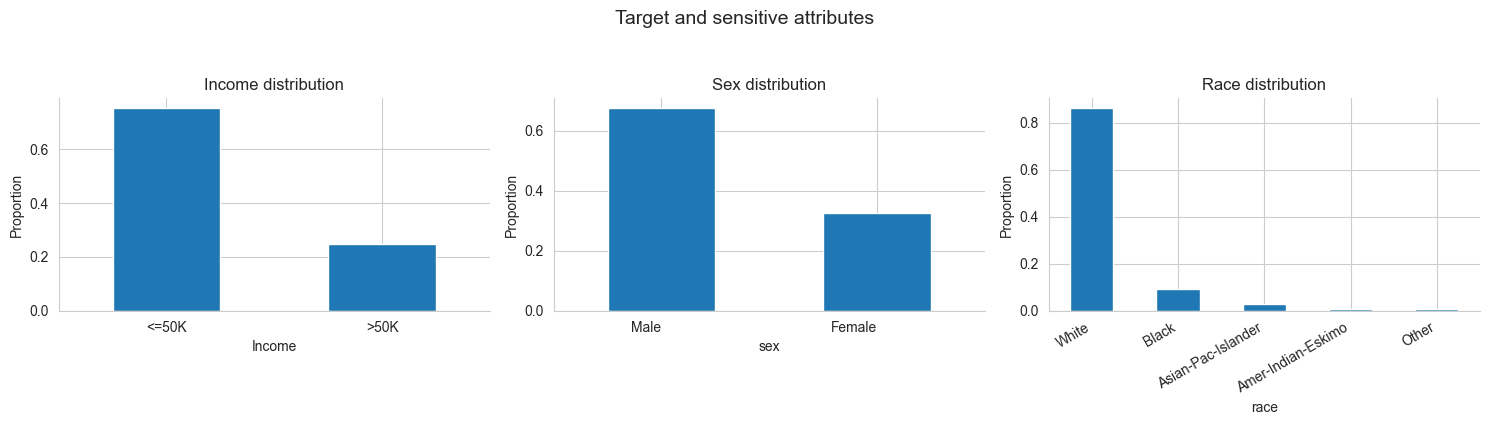

In [5]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Target (income)
income_prop = df_full[target_col].value_counts(normalize=True)
income_prop.plot(kind='bar', ax=axes[0])
axes[0].set_title('Income distribution')
axes[0].set_ylabel('Proportion')
axes[0].set_xlabel('Income')
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=0)

# Sex distribution
plot_group_counts(
    df_full,
    'sex',
    ax=axes[1],
    normalize=True,
    title='Sex distribution',
    ylabel='Proportion',
)

# Race distribution
plot_group_counts(
    df_full,
    'race',
    ax=axes[2],
    normalize=True,
    title='Race distribution',
    ylabel='Proportion',
    rotation=30,
)

fig.suptitle('Target and sensitive attributes', fontsize=14, y=1.05)
fig.tight_layout()


## 5. Income gaps by sex and race

We now look at how often each group receives the **positive outcome** (income > 50K).
These group-wise positive rates are what drive fairness metrics like
**Statistical Parity Difference (SPD)** and **Disparate Impact (DI)**.

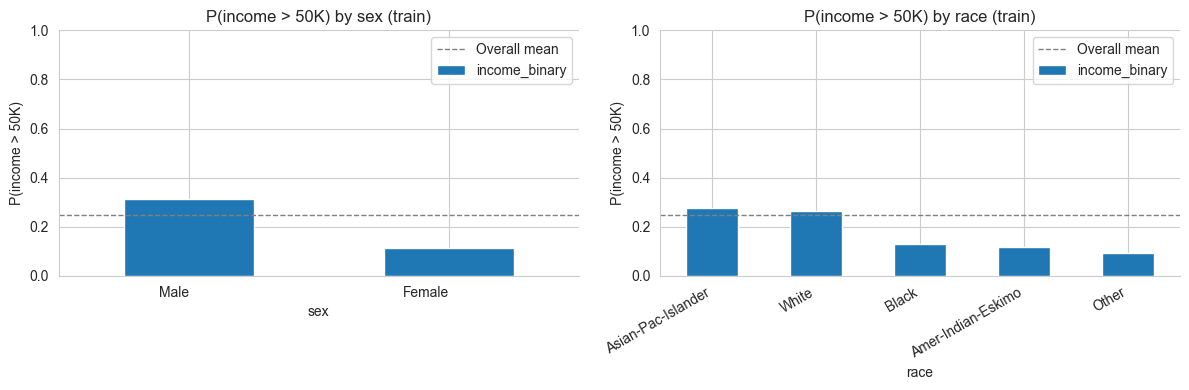

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

plot_group_positive_rate(
    df_train,
    'sex',
    target_col='income_binary',
    ax=axes[0],
    title='P(income > 50K) by sex (train)',
)

plot_group_positive_rate(
    df_train,
    'race',
    target_col='income_binary',
    ax=axes[1],
    title='P(income > 50K) by race (train)',
    rotation=30,
)

fig.tight_layout()


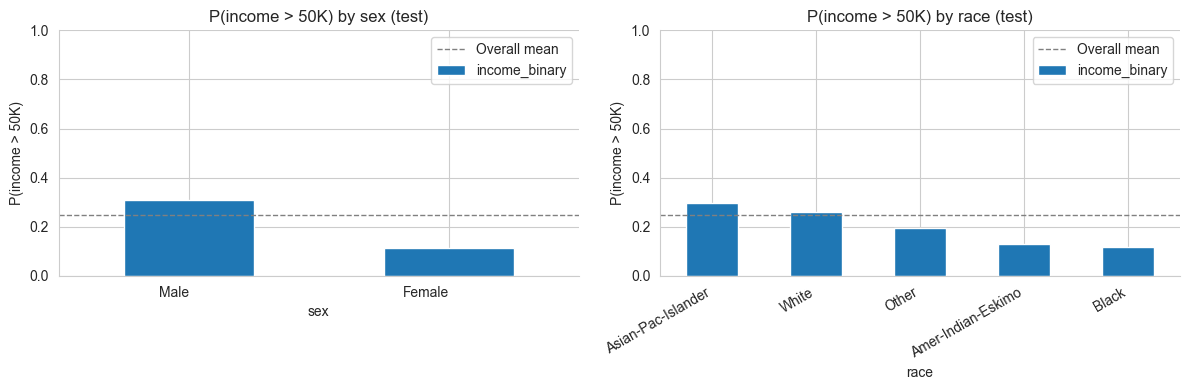

In [7]:
if df_test is not None and len(df_test) > 0:
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    plot_group_positive_rate(
        df_test,
        'sex',
        target_col='income_binary',
        ax=axes[0],
        title='P(income > 50K) by sex (test)',
    )

    plot_group_positive_rate(
        df_test,
        'race',
        target_col='income_binary',
        ax=axes[1],
        title='P(income > 50K) by race (test)',
        rotation=30,
    )

    fig.tight_layout()
else:
    print('No separate test split available.')


## 6. Intersectional view: sex × race

To capture possible *intersectional* effects we look at income rates for
combinations of sex and race.

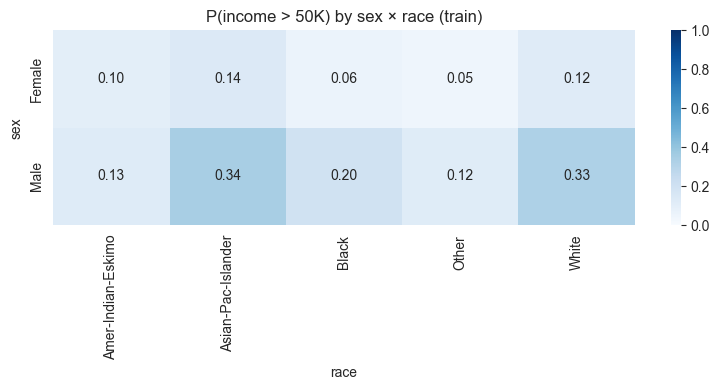

In [8]:
pivot = (
    df_train
    .groupby(['sex', 'race'])['income_binary']
    .mean()
    .reset_index()
    .pivot(index='sex', columns='race', values='income_binary')
)

fig, ax = plt.subplots(1, 1, figsize=(8, 4))
sns.heatmap(
    pivot,
    annot=True,
    fmt='.2f',
    cmap='Blues',
    vmin=0,
    vmax=1,
    ax=ax,
)
ax.set_title('P(income > 50K) by sex × race (train)')
plt.tight_layout()


## 7. Numeric drivers of income

We inspect which numeric features correlate most with the income label and
visualise a few of them split by income group.

In [9]:
corr_to_income = (
    df_train.corr(numeric_only=True)['income_binary']
    .sort_values(ascending=False)
)
display(corr_to_income)


income_binary     1.000000
education_num     0.335413
age               0.242017
hours_per_week    0.229435
capital_gain      0.221204
capital_loss      0.150026
fnlwgt           -0.008992
Name: income_binary, dtype: float64

Top numeric features by correlation with income_binary: ['education_num', 'age', 'hours_per_week', 'capital_gain']

Distribution of education_num by income group


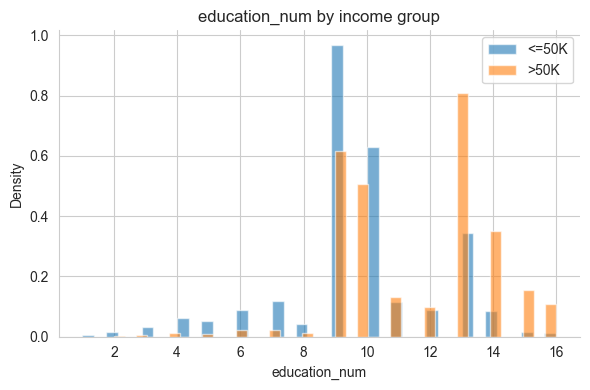


Distribution of age by income group


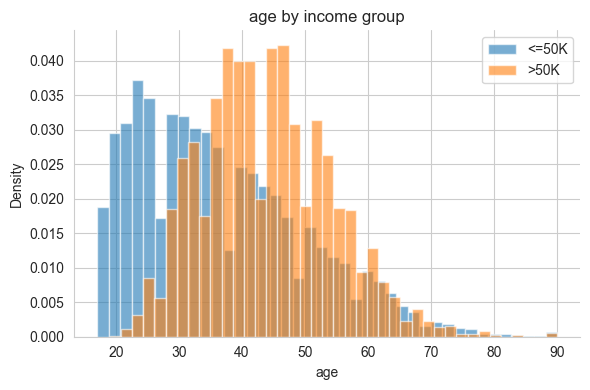


Distribution of hours_per_week by income group


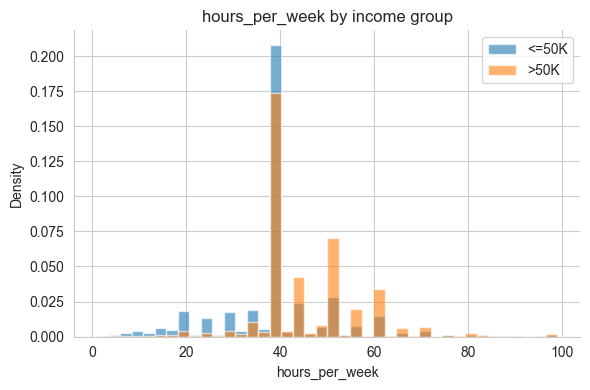


Distribution of capital_gain by income group


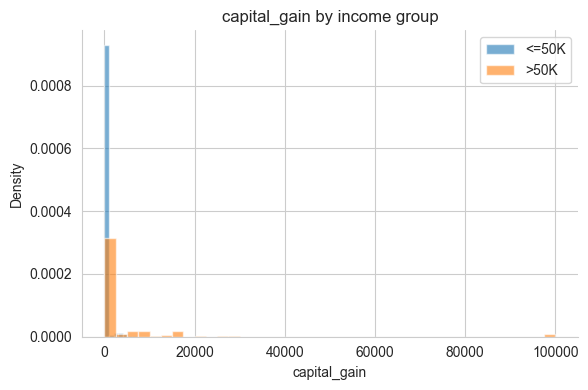

In [10]:
top_numeric = [col for col in corr_to_income.index if col != 'income_binary'][:4]
print('Top numeric features by correlation with income_binary:', top_numeric)

for col in top_numeric:
    print('\n' + '=' * 60)
    print(f'Distribution of {col} by income group')
    plot_numeric_by_target(df_train, col, target_col='income_binary')
    plt.show()


## 8. Train vs test balance for sensitive attributes

We check that **sex** and **race** distributions are similar between train and
test splits, to ensure a fair evaluation setup.

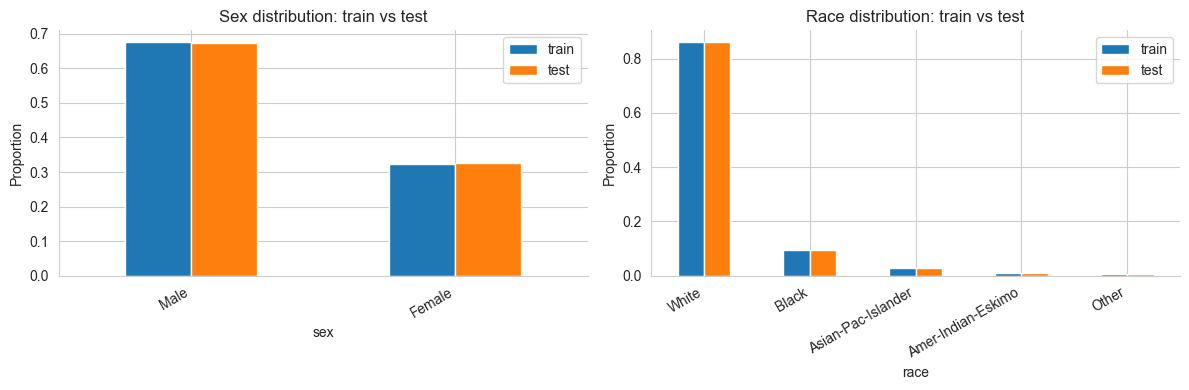

In [11]:
if df_test is not None and len(df_test) > 0:
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    for ax, col, title in zip(
        axes,
        ['sex', 'race'],
        ['Sex distribution: train vs test', 'Race distribution: train vs test'],
    ):
        train_dist = df_train[col].value_counts(normalize=True).rename('train')
        test_dist = df_test[col].value_counts(normalize=True).rename('test')
        dist = pd.concat([train_dist, test_dist], axis=1)
        dist.plot(kind='bar', ax=ax)
        ax.set_title(title)
        ax.set_ylabel('Proportion')
        ax.set_xlabel(col)
        ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right')

    fig.tight_layout()
else:
    print('No separate test split available.')


## 9. Numeric correlation heatmap (optional)

A quick overview of correlations between all numeric features,
including the binary income label.

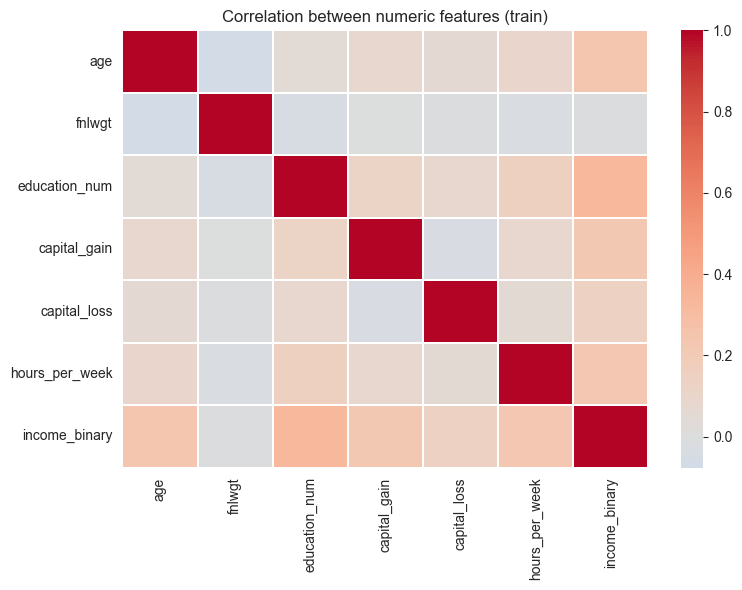

In [12]:
numeric_cols = df_train.select_dtypes(include='number').columns
corr_matrix = df_train[numeric_cols].corr()

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
sns.heatmap(
    corr_matrix,
    cmap='coolwarm',
    center=0,
    annot=False,
    linewidths=0.1,
)
ax.set_title('Correlation between numeric features (train)')
plt.tight_layout()
